## 1.Importing Libraries

In [25]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

## 2. Import Data

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'PPgwq6iFSK4jRjScgFBP'

In [3]:
# Importing Inflation YOY - EURO Area
data = quandl.get ('RATEINF/INFLATION_EUR')

## 3. Data Wrangling and Cleaning

In [4]:
# Display dataframe first 5 rows
data.head(5)

,Value
Date,
1991-01-31,3.90
1991-02-28,4.13
1991-03-31,3.88
1991-04-30,3.85
1991-05-31,4.10


In [5]:
data.tail(5)

,Value
Date,
2021-10-31,4.05
2021-11-30,4.87
2021-12-31,4.96
2022-01-31,5.11
2022-02-28,5.87


In [6]:
#checking the shape of the data
data.shape

(374, 1)

In [7]:
# Check column info
data.columns

Index(['Value'], dtype='object')

In [8]:
# Check data type
type(data)

pandas.core.frame.DataFrame

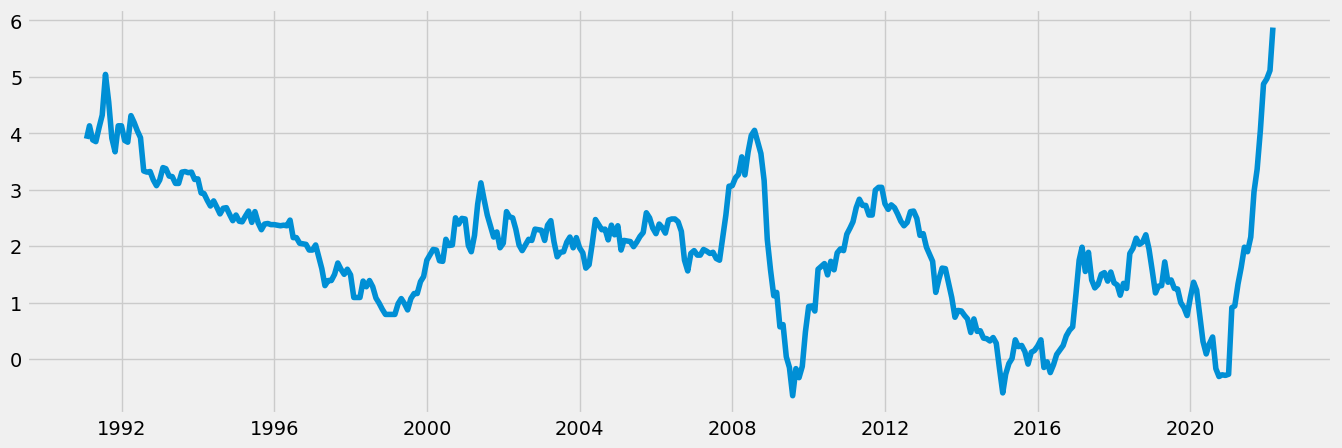

In [9]:
# Plot the data using matplotlib
plt.figure(figsize=(15,5), dpi=100) 

plt.plot(data)

I chose not to create a subset with this data. As the data is from 1988 to 2020, there are no irrelevant historical events and no forecasted data in this time frame that would result in bias in the analysis.

In [10]:
# Check for missing values 
data.isnull().sum() 

Value    0
dtype: int64

In [11]:
# Check for duplicates
dups = data.duplicated()
dups.sum()

136

In [19]:
#Dropping Duplicate
data.drop_duplicates(inplace=True)

In [22]:
#checking new shape of our data
data.shape

(238, 1)

## 4. Time-series analysis: decomposition

In [29]:
# Decompose time series using multiplicative model
decomposition = sm.tsa.seasonal_decompose(data, model='additive')

In [30]:
# Define a fixed size for all special charts
from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

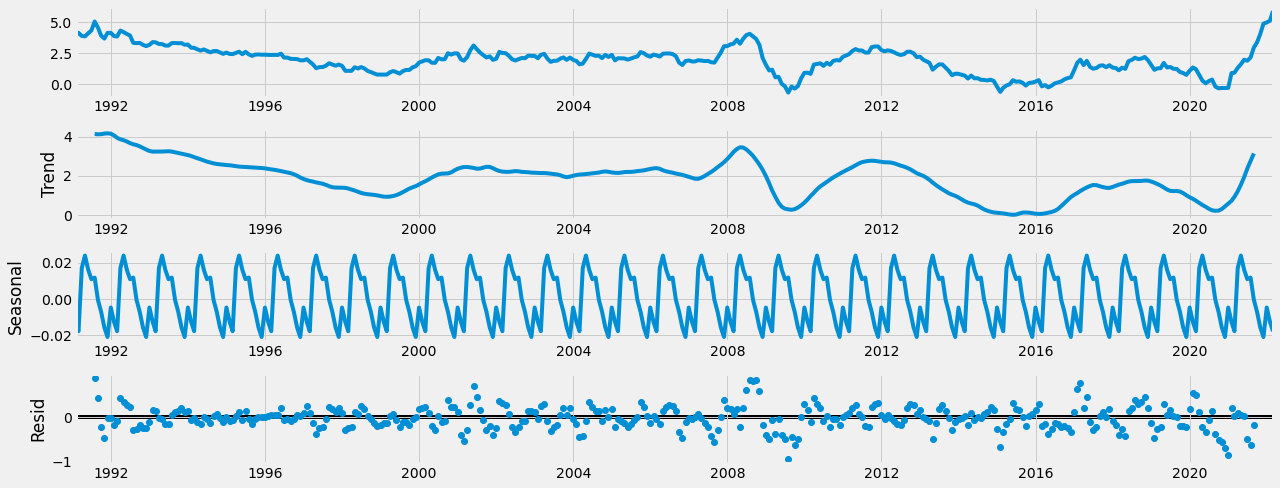

In [31]:
# Plot separate components
decomposition.plot()
plt.show()

The data is split into three component, the data is unsmoothed in this matter, inflation rate in the EU zone has been declining from 1992 and remained stable until a drop in 2008 (global financial crisis), it went up and down but under normal nevel. there has been a significant increase by the end of 2020 (covid-19 pandemic and lockdown around the world).

Seasonal component display fluctuations indicating season fluctuation at a regular interval.

There is much unexplained noise - but we know that already since the data is unsmoothed.

## 5. Test for Stationary

In [16]:
# Import adfuller() function, perform Dickey-Fuller Test, and apply test using function on time series

from statsmodels.tsa.stattools import adfuller 

def dickey_fuller(timeseries): 
    
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.879545
p-value                          0.047779
Number of Lags Used             14.000000
Number of Observations Used    359.000000
Critical Value (1%)             -3.448697
Critical Value (5%)             -2.869625
Critical Value (10%)            -2.571077
dtype: float64


The test statistic is -2.87 and the p-value is 0.04 which indicates the test result significant as it is less than 0.05. Using the critical value (5%) which is -2.86 it is slightly smaller than the test statistic. This means you cannot reject the null hypothesis. This indicates that there is a unit root in the data and that the data is likely non-stationary.

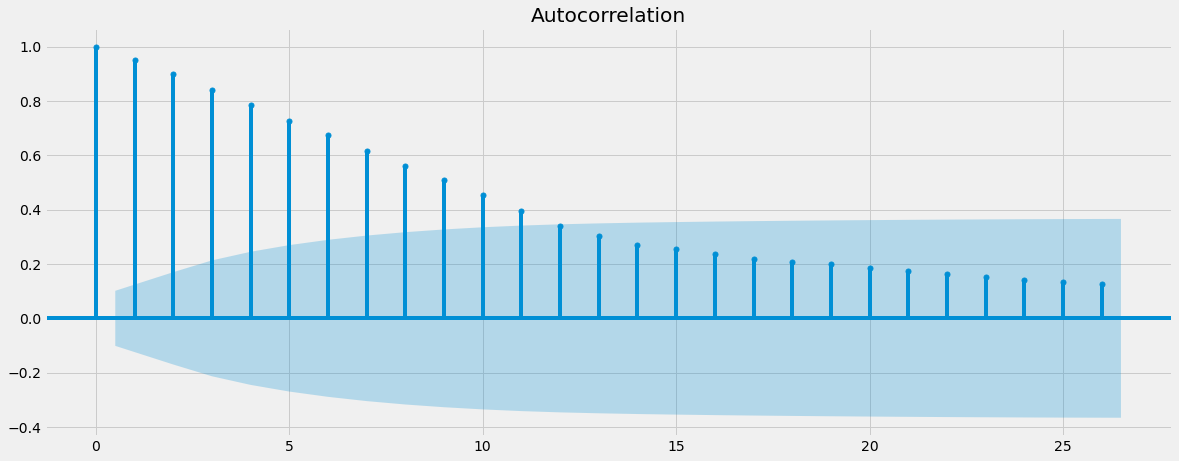

In [17]:
# Plot autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data)
plt.show()

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means we have lags that are significantly correlated with each other. And when you have many lags beyond this interval, you can state that our data is non-stationary.

## 6. Stationarize the Data

In [18]:
# Calculate difference between every values and its lag, then store results in new dataframe
data_diff = data - data.shift(1) 

In [19]:
# Remove any missing values
data_diff.dropna(inplace = True) 

In [20]:
# Display dataframe
data_diff.head()

,Value
Date,
1991-02-28,0.23
1991-03-31,-0.25
1991-04-30,-0.03
1991-05-31,0.25
1991-06-30,0.22


In [21]:
# Display column information
data_diff.columns

Index(['Value'], dtype='object')

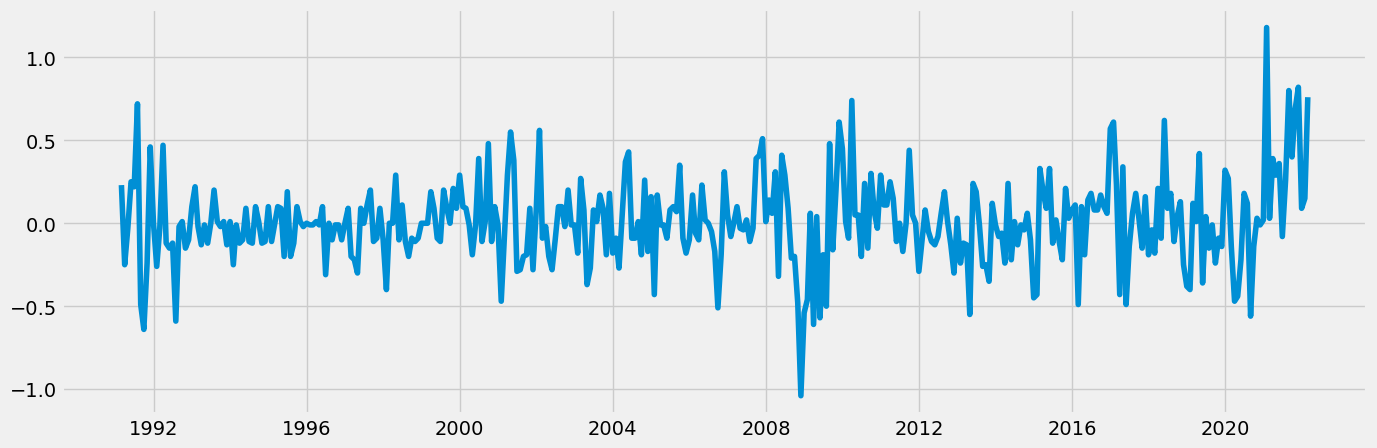

In [22]:
# Display time series with differencing
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [23]:
# Perform Dickey-Fuller test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -5.186705
p-value                          0.000009
Number of Lags Used             13.000000
Number of Observations Used    359.000000
Critical Value (1%)             -3.448697
Critical Value (5%)             -2.869625
Critical Value (10%)            -2.571077
dtype: float64


With differencing, the test-statistic (-5.0) is now smaller than the critical values at 5% (-2.8) and at 10% (-2.5). The null hypothesis can be rejected and the series is now stationary. The test result is also significant as the p-value is less than 0.05.

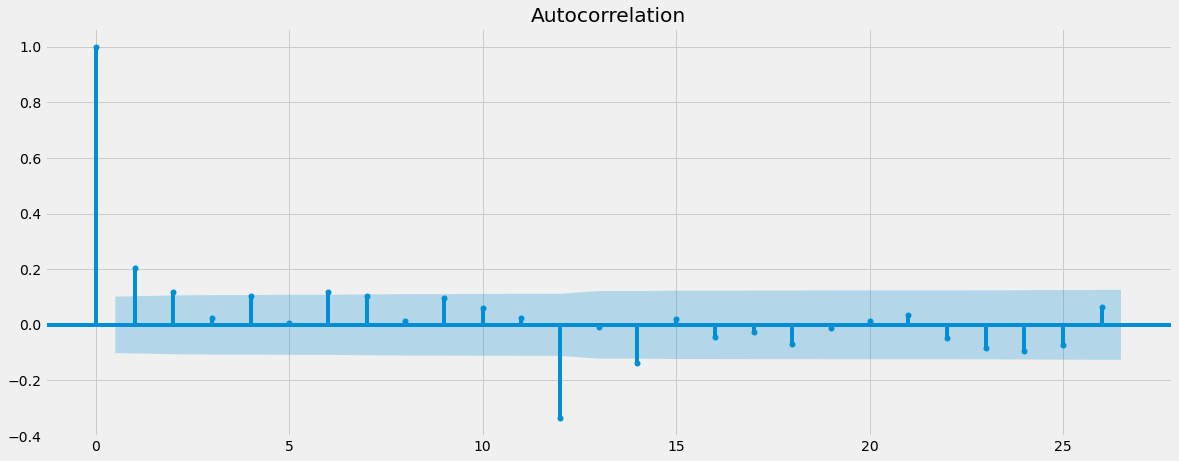

In [24]:
# Display autocorrelation
plot_acf(data_diff)
plt.show()

The autocorrelation is significantly different with few autocorrelated terms. However, as there are still lags outside of the confidence interval, it indicates a weak stationarity. As there are less than 10 significant lags, a second round of differencing is not necessary.